In [1]:
import os
import random
import sys
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Использовать только процессор.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Изменить уровень отображения логов
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

# Корень проекта.
DIR_ROOT = Path.cwd().parent.parent
sys.path.append(str(DIR_ROOT))
import src.model_utils as mu
from src.logger import eval_log_to_json, mean_epochs

# Путь к удаленной директории с ресурсами: данные, модели и т.д.
DIR_REMOTE: Path | None = Path('/home/admin/cafa/resources')

if DIR_REMOTE is not None and DIR_REMOTE.exists():
    DIR_RESOURCE = DIR_REMOTE
else:
    DIR_RESOURCE = DIR_ROOT

# Путь к директории с подготовленными данными.
DIR_PREPARED_DATA = DIR_RESOURCE / 'data/prepared'
# Путь к файлу с оценкой моделей для различных экспериментов.
PATH_TO_EVAL_FILE = DIR_ROOT / 'experiments/eval.json'

# Утилиты

In [2]:
def print_shape_and_total_memory(df: pd.DataFrame, prefix: str = '') -> None:
    '''
    Вывод информации о форме и общем размере занятой памяти
    объектаpd.DataFrame
    '''
    print(
        prefix,
        f'Shape: {df.shape}',
        f'Total memory: {df.memory_usage().sum() / 1024**3:.1f} GB',
        '---',
        sep='\n',
    )


# Загрузка данных (признаков, целей, IA-коэффициентов)

In [3]:
PATH_TO_FEATURES = DIR_PREPARED_DATA / 'train_features_v2.csv'
PATH_TO_LABELS = DIR_PREPARED_DATA / 'train_lbls_top1500_goterms_v2.csv'
PATH_TO_IA_ARR = DIR_PREPARED_DATA / 'ai_arr_top1500_goterms_v2.npy'
# Загрузка признаков.
x = pd.read_csv(PATH_TO_FEATURES)
# Загрузка целей.
y = pd.read_csv(PATH_TO_LABELS)
y = y.astype('int32')
# Загрузка массива IA коэффициентов, соответсвующих GO-термам в `y.columns` 
ia_arr = np.load(PATH_TO_IA_ARR)

print_shape_and_total_memory(x, 'x:')
print_shape_and_total_memory(y, 'y:')
print(f'ia_arr:\nShape: {ia_arr.shape}')

x:
Shape: (142246, 1024)
Total memory: 1.1 GB
---
y:
Shape: (142246, 1500)
Total memory: 0.8 GB
---
ia_arr:
Shape: (1500,)


# Оценка модели

## Оценка производительности модели
Оценка производительности модели через KFold кросс-валидацию.

In [9]:
ACTIVATION = 'relu'
BATCH_SIZE = 5000
# Список для создания `Сallbacks` объектов. 
CALLBACKS_PARAMS: list[mu.CallbackParams] = [
    {
        'callback': tf.keras.callbacks.EarlyStopping,
        'params': {
            'monitor': 'val_loss',
            'mode': 'min',
            'min_delta': 0.01,
            'patience': 10,
            'restore_best_weights': True,
        }
    },
]
# None или результат `mu.create_callbacks(CALLBACKS_PARAMS)`
CALLBACKS = mu.create_callbacks(CALLBACKS_PARAMS)
DROPOUT = 0.5
EPOCHS = 150
KERNEL_REGULARIZER = None
# Структура скрытых слоев в последовательной DNN.
LAYERS_STRCT = [1024, 512, 1024]
LEARNING_RATE = 0.001
LOSS = mu.WeightedBinaryCrossentropy(
    mu.calculating_class_weights(y.to_numpy())
)
# LOSS = mu.WeightedBinaryCrossentropy()
# Число циклов с кросс-валидацией.
N_REPEATS = 1
# Число фолдов в кросс-валидации.
N_SPLITS = 5
# Параметры для формирования метрик.
METRIC_TH_STEP = 0.01
METRIC_TAU = 0.5
# Список метрик, используемых для рассчета произовдительности модели.
METRICS = [
    mu.f1_score_micro,
    mu.ia_f1_score_micro,
    mu.metric_ia_closure(
        metric_func=mu.ia_f1_score_weighted,  # type: ignore
        metric_name='iaw_f1',
        tau=METRIC_TAU,
    ),
    mu.metric_ia_closure(
        metric_func=mu.ia_f1_score_weighted_max,  # type: ignore
        metric_name='iaw_f1_max',
        tau_arr=np.arange(METRIC_TH_STEP, 1, METRIC_TH_STEP),
    )
]
RANDOM_STATE = 5917 # random.randint(0, 10_000)
SHUFFLE = True
VALIDATION_SPLIT: float | None = None
VERBOSE = 1


# Формирование фабрики скомпилированных моделей.
mfabric = mu.ModelCompileFabric(
    activation=ACTIVATION,
    kernel_regularizer=KERNEL_REGULARIZER,
    dropout=DROPOUT,
    layers_strct=LAYERS_STRCT,
    learning_rate=LEARNING_RATE,
    loss=LOSS,
)
# Создаем прокси для обучения моделей.
mproxy = mu.ProxyFitModel(
    mfabric,
    batch_size=BATCH_SIZE,
    callbacks=CALLBACKS,
    epochs=EPOCHS,
    shuffle=SHUFFLE,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
)
# Оценка производительности модели через кросс-валидацию.
results = mu.evaluate_model(
    features=x.to_numpy(),
    lbls=y.to_numpy(),
    metrics=METRICS,  # type: ignore
    ia_arr=ia_arr,
    proxy_model=mproxy,
    n_repeats=N_REPEATS,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE,
)

Epoch 1/150
23/23 [==============================] - 18s 719ms/step - loss: 0.2085 - binary_accuracy: 0.9328 - val_loss: 0.5811 - val_binary_accuracy: 0.9799
Epoch 2/150
23/23 [==============================] - 16s 692ms/step - loss: 0.0856 - binary_accuracy: 0.9795 - val_loss: 0.5606 - val_binary_accuracy: 0.9800
Epoch 3/150
23/23 [==============================] - 16s 679ms/step - loss: 0.0804 - binary_accuracy: 0.9798 - val_loss: 0.5459 - val_binary_accuracy: 0.9801
Epoch 4/150
23/23 [==============================] - 16s 686ms/step - loss: 0.0779 - binary_accuracy: 0.9800 - val_loss: 0.5279 - val_binary_accuracy: 0.9802
Epoch 5/150
23/23 [==============================] - 16s 685ms/step - loss: 0.0755 - binary_accuracy: 0.9801 - val_loss: 0.5041 - val_binary_accuracy: 0.9803
Epoch 6/150
23/23 [==============================] - 16s 678ms/step - loss: 0.0733 - binary_accuracy: 0.9802 - val_loss: 0.4852 - val_binary_accuracy: 0.9804
Epoch 7/150
23/23 [==============================] -

## Сохранение результатов
Сохранение результатов оценки производительности модели и сопутсвующих параметров. 

In [10]:
data_info_dict = {
    'file_name_features': PATH_TO_FEATURES.name,
    'file_name_labels': PATH_TO_LABELS.name,
    'file_name_ia_arr': PATH_TO_IA_ARR.name,
}
model_params_dict = {
    'activation': ACTIVATION,
    'batch_size': BATCH_SIZE,
    'callbacks': (
        CALLBACKS if CALLBACKS is None
        else mu.create_callbacks_info(CALLBACKS_PARAMS)
    ),
    'dropout': DROPOUT,
    'epochs': EPOCHS,
    'kernel_regularizer': KERNEL_REGULARIZER,
    'layers_strct': LAYERS_STRCT,
    'learning_rate': LEARNING_RATE,
    'loss': LOSS.name,
    'n_repeats': N_REPEATS,
    'n_splits': N_SPLITS,
    'mean_epoch': mean_epochs(results[1]),
    'random_state': RANDOM_STATE,
    'shuffle': SHUFFLE,
    'validation_split': VALIDATION_SPLIT,
}
# Формируем словарь с текущей оценкой производительности модели
# и сопутсвующими параметрами.
model_eval_params: mu.ModelEvalParams = {
    'data_info': data_info_dict,
    'model_params': model_params_dict,
    'scores': mu.get_scores_stats(results[0], ndigits=3),
}
cur_datetime = datetime.now().strftime('%Y_%d%b%H_%M_%S')
# Записываем результаты текущей оценки производительности модели в файл.
eval_log_to_json(
    log_file=DIR_ROOT / 'experiments/eval.json',
    params={f'dt{cur_datetime}': model_eval_params},
)

Файл был дополнен


## Построение loss-функций

loss
binary_accuracy
val_loss
val_binary_accuracy


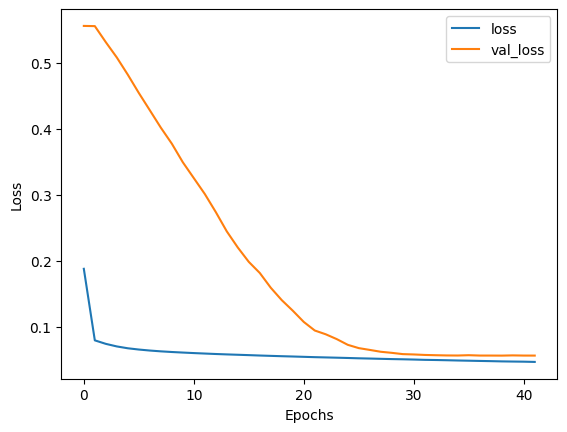

In [6]:
history_1 = results[1][1]
for key in history_1.history.keys():
    print(key)

fig, ax = plt.subplots()
ax.plot(history_1.history['loss'], label='loss')
ax.plot(history_1.history['val_loss'], label='val_loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()